# **9장 비지도 학습**

비지도 학습 : 클러스터링, 차원 압축, 이상 감지  
우리는 클러스터링만 다룰 것.  

학습레이블이 없는 학습을 의미하기 때문에, 데이터의 분포나, 데이터의 특성을 파악하는 일에 국한될 수 밖에 없다는 점.

# **9.1 2차원 입력 데이터**

입력 데이터 X : 6장에서 다룬 2차원 입력 데이터를 사용할 것. 하지만, 비지도 학습이기 때문에 정답인 T를 사용하지는 않는다는 것.  

클러스터링 : 클래스(정답) 정보 없이 입력 데이터가 비슷한 애들 끼리 클래스로 나누는 것. 군집화  

아래 그림을 보면 알겠지만, 굳이 클래스에 대한 정보가 없어도, 인근에 붙어있는 것들 끼리 군집화를 하고, 이 군집화를 바탕으로 label을 먹일 수 있다는 것.  

이를 사용할 수 있는 예시를 정리해보면, 동일 클러스터에 속하면 닮았고, 다른 클러스터라면 닮지 않은 것으로 볼 수 있는데, 이를 고객 데이터를 기반으로 clustering 한다고 하면, 각 층(주부, 직장인) 등으로 나누고, 각 손님층에 대한 별도의 판매 전략등을 수립할 수도 있을 것이다.

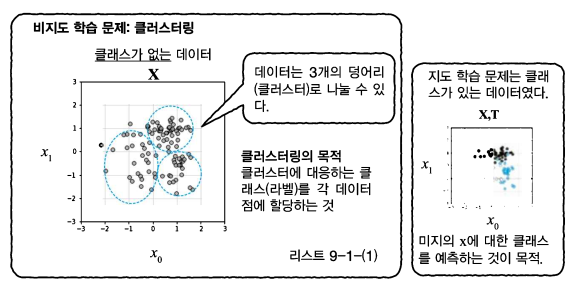

우리가 할 예제는 K-means 기법과 가우시안 혼합 모델을 통한 클러스터링을 할 것이다.

<ipython-input-1-0256df924b5e>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]


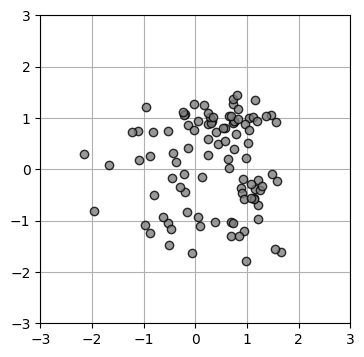

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성 --------------------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기 ------------------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)

# **9.2 K-means**

# **9.2.1 K-means 기법의 개요**

K-means 기법에서도 다음장의 가우시안 혼합 모델의 경우에도 미리 분할할 클러스터의 수 K 를 결정해야 합니다. 이 예저에서 K = 3으로 분류한다고 가정하고 시작할게요.  
K-means에서 사용할 변수는 총 2개로 클러스터의 중심을 나타내는 μ 와 클래스 지시 변수 R 이며, 각 데이터들이 어떤 클러스터에 속하는지를 나타내는 역할을 한다.

step0 : 클러스터의 중식 벡터 μ 에 들어갈 적절한 값을 제공  
step1 : 현 시점의 클러스터의 중심 벡터 μ 를 바탕으로 R을 결정  
step2 : 현 시점 클래스 지시 변수 R 로 μ 를 갱신

이후 step 1 과 step 2의 반복을 통해 μ 와 R 에 대한 갱신을 계속하다. 더이상 수정이 없으면 절차를 종료한다.

# **9.2.2 Step 0 : 변수의 준비와 초기화**

k 번째 클러스터의 중심 벡터는 [식 9 - 1] 로 나타낸다.

$μ_k$ = $[μ_{k0}, \mu_{k1}]$ 가 중심 벡터가 된다.

입력 : 2차원  
클러스터의 중심 : 2차원  
중심 벡터 : 알고리즘의 최초의 적당한 초기값 제공

우리의 예시에서 K = 3 이므로, 중심 벡터를 일단
$\mu_0 = [-2, 1], μ_1 = [-2, 0], μ_2 = [-2, -1]$ 로 하겠다.  

클래스 지시변수는 2개의 상태를 갖고   
1 : 해당 클래스에 속함.   
0 : 해당 클래스에 속하지 않음.

즉 one hot encoding 의 상태로 나타내며, $r_n = [r_{n0}, r_{n1}, r_{n2} = [1, 0, 0]$ 로 나타낼 수 있다.

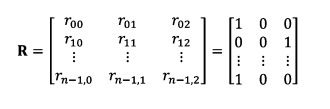

In [2]:
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype = int), np.zeros((N, 2), dtype = int)] # (N, 1) 1행렬 (N, 2) 0행렬 붙이기



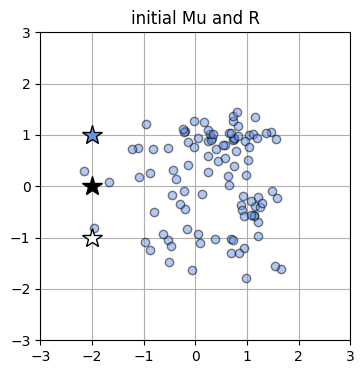

In [3]:
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

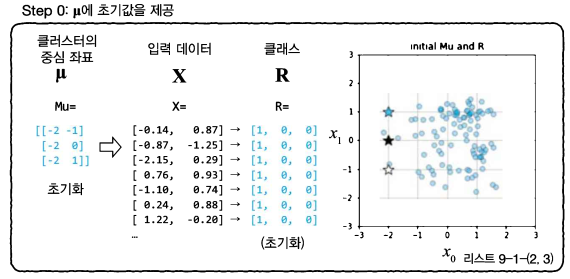

# **9.2.3 Step 1: R의 갱신**

R을 갱신해보자,  
여기서 R을 update 하는 주요 개념은 "각 데이터 점을 가장 중심이 가까운 클러서에 넣는다" 이다.

1. 각 데이터 점에서 클러스터의 중심까지의 제곱 거리를 각 클러스터에 대해 계산한다.  


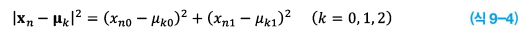

2. 그 결과 0, 1, 2 까지의 제곱거리를 바탕으로 가장 가까운 클러스터 점을 찾고 그 클러스터 점을 class 변수로 쓴다.

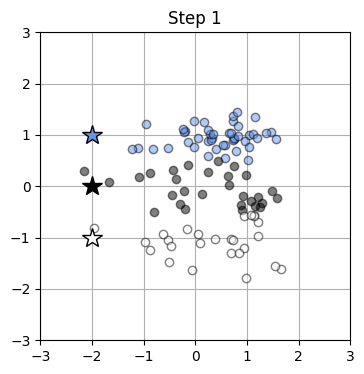

In [4]:
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# ------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

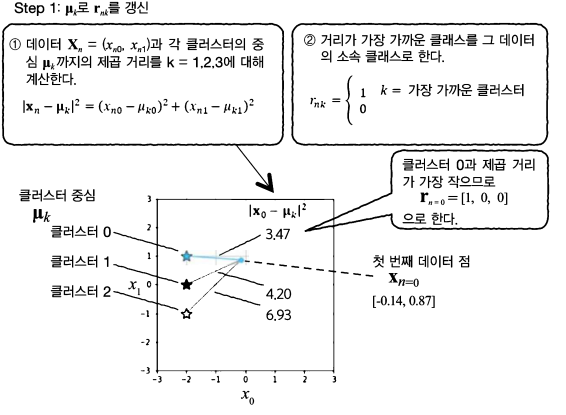

각 점을 기준으로 가장 가까운 점에 대해 cluster 된 것을 볼 수 있다.

# **9.2.4 Step 2 : μ의 갱신**

μ를 갱신해야 하는데, μ에 대한 갱신 방법은 "각 클러스터에 속하는 데이터의 점의 중심을 새로운 μ 로 한다" 라는 것이다.

먼저 k = 0 에 속하는 데이터 즉, $r_n$ = [1, 0, 0] 이라는 라벨을 가진 데이터 점에 주목해 각 평균을 구한다.

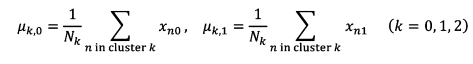

μ {k, x} 에서 x는 특별한 변수가 아닌 열에 대한 값임을 이해.  


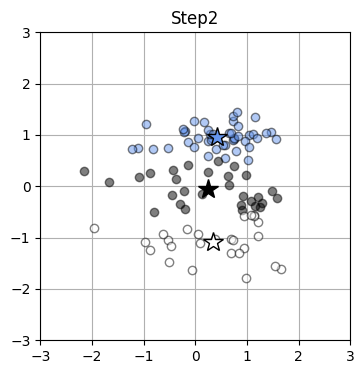

In [5]:
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# ------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

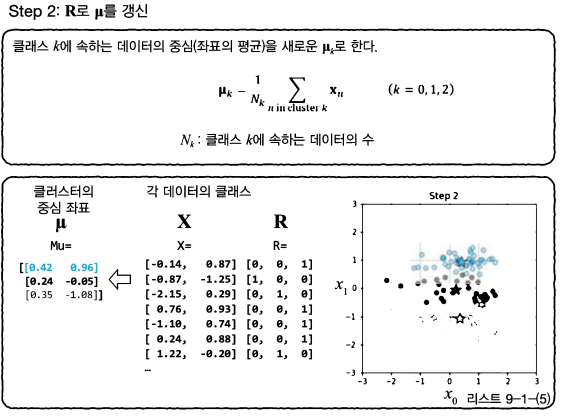

이걸로 K-means 에 대한 설명이 끝났다 이제 우리가 할 것은 더 이상의 변화가 생기기 전까지, step1 과 step2 를 반복해주는 것 뿐이다.

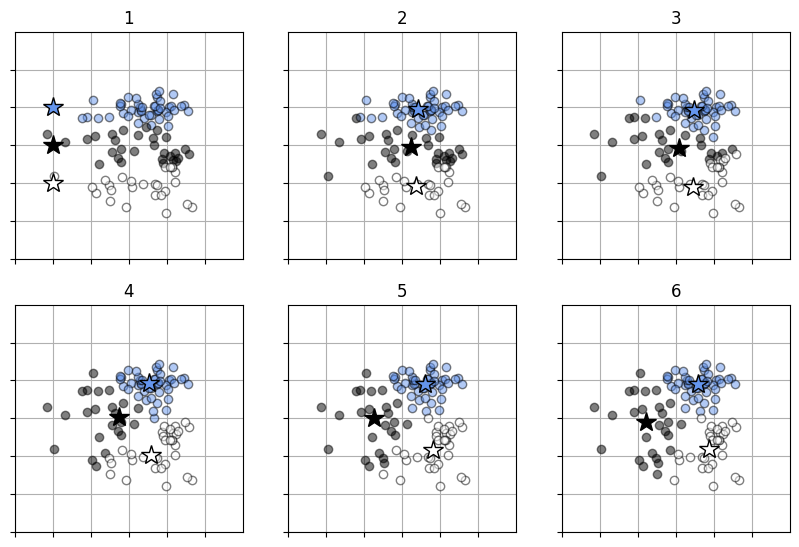

In [6]:
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

# **9.2.5 왜곡 척도**

비지도 학습이 오차 함수처럼 학습이 진행됨에 따라 감소하는 목적함수가 없는 이유는 뭘까?  
사실 K-means 의 경우 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합한 것이 목적함수에 대응하고, 왜곡 척도라고 부른다.

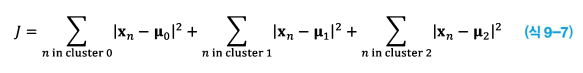

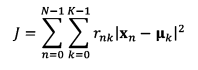

아래 코드는 왜곡 척도를 계산하는 코드이며, μ 와 R을 초기화도 같이 한다.

In [7]:
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

위의 예시는 초기값의 왜곡 척도에 대한 계산을 나타낸 것이다.

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


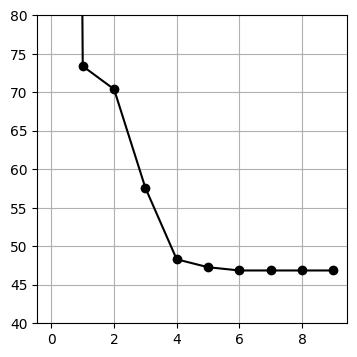

In [8]:
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

왜곡 척도에 대한 그림인데, 이 예제에서는 6회 째에 수렴한다.

K-means의 문제는 초기값에 대한 의존성이다.  

즉 초기값의 설정에 따라 최종결과가 달라질 가능성이 높다. 일반적으로 실제 산업에서 사용한다고 하면 여러 μ 에 대해 왜곡 척도가 작은 아이들을 통해 학습을 시작한다고 한다.

# **9.3 가우시안 혼합 모델**

가우시안 혼합 모델을 이용한 클러스터링에 대해 생각하자.

# **9.3.1 확률적 클러스터링**

K-means 기법은 모든 data가 어떤 한 점의 클러스터에 해당해야 한다는 점이 있는데, 이게 맘에 안든다. 즉 내가 하고 싶은것은 모호성에 대한 수치화이고, 이게 나타내는 것은 A 가 클러스터 0에 속하지만, B는 클러스터 0과 1에 모두 속해있다를 나타내고 싶다면, 어떤 방법이 있을까? 이 때는 바로 확률의 개념이 들어가야만 한다.

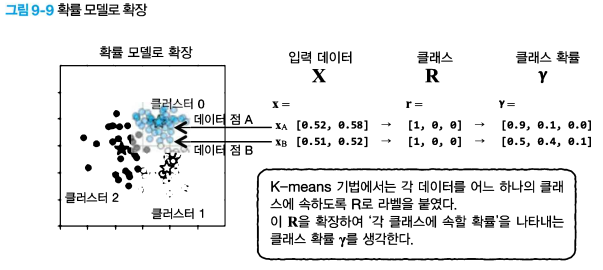

모호성에 대한 수치화를 위해, γ 라는 수식을 통해 나타낼 것이고, 아래와 같이 나타낸다.

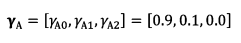

어떤 쪽의 클러스터에는 반드시 속하기 때문에, 3개의 확률을 더하면 1이 되어야 하며, K-means 로 다룬 R의 확장 개념이라고 생각하면 된다. 클러스터 0의 가장자리의 데이터 B는 클러스터에 대한 수치를 이런 식으로 나타낼 수 있다. $γ_B = [γ_{B0}, γ_{B1}, γ_{B2}] = [0.5, 0.4, 0.1]$ 이런 식으로 나타낼 수 있다.

클러스터 k에 속할 확률에 대해서 의미적으로 살펴보면, 지금 생각중인 2차원 입력 데이터 x = $[x_0, x_1]$ 은 곤충의 질량과 크기를 나타내고 있다고 하면, 각 클러스터에 의해 질량과 크기가 대략 정해지는데, 이게 폭이 넓어졌다고 생각하면 단순한 이해가 가능.

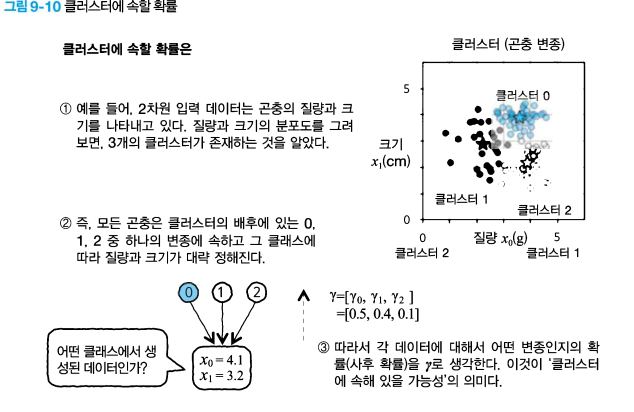

여러 마리를 채취하여 질량과 크기의 데이터를 기록하고 200마리를 모아 plot 했을 때, 3개의 클러스터가 나타났다고 하자. 이 경우 수집한 곤층들은 어떤 분명한 차이들이 있으며, 이에 따라 질량과 크기가 정해진다고 생각할 수 있으며, 3개의 클러스터 뒤에는 3개의 클래스가 있다는 것이 암시된 것이다. 이렇게 관찰은 못했지만, 영향을 준 변수를 잠재 변수, 숨은 변수라고 합니다.

이 잠재변수를 3차원의 벡터를 이용해 one-hot-encoding 으로 나타내면 다음과 같이 나타낼 수 있고,

$$Z_n = [Z_{n0}, Z_{n1}, Z_{n2}]$$

K-means 기법의 R과 거의 같은데, 잠재 변수라는 의미를 강조하기 위해 굳이 Z 로 나타냈다.

γ 는 어떤 클러스터가 얼마나 기여하고 있는가 를 나타내기 위해 부담률이라고 한다.

**즉 관측할 수 없는 Z를 확률적인 γ 로 추정하는 것이다.**

# **9.3.2 가우시안 혼합 모델**

부담률 γ 를 구하기 위해 가우시안 혼합 모델을 소개한다.

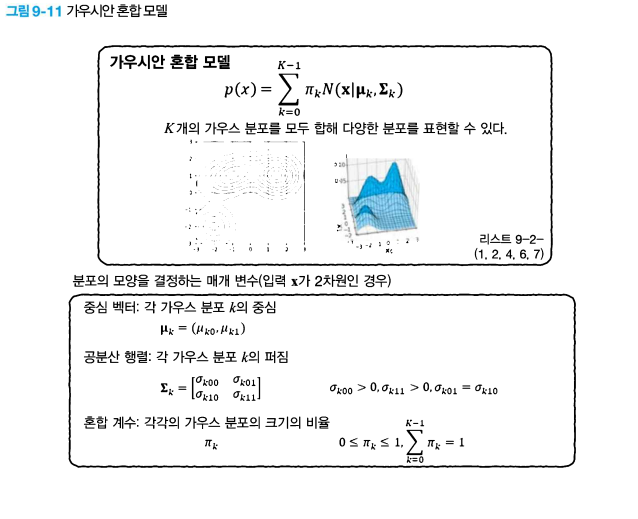

2차원 가우스 함수 여러 개를 합친 것을 가우시안 혼합 모델이라고 한다.

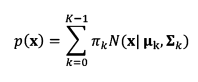

즉 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수를 K개 겹친 분포를 말한다.

K = 3 일 때의 가우시안 혼합 모델을 볼 것 이다. 중심과 분포의 퍼짐이 다른 가우스 분포 3개를 겹치는 형태를 말한다.

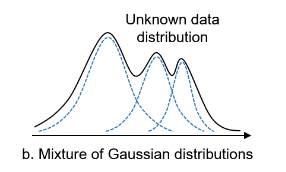

In [9]:
import numpy as np
#9.1 절에서 만든 데이터 X와 그 범위 X_range0, X_range1 을 로드
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [10]:
#가우스 함수에 대한 정의
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

x : 데이터 행렬  

mu : 길이가 D 인 중심 벡터  

sigma : D x D 의 공분산 행렬

In [11]:
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


가우스 함수를 여러번 더해 가우시안 혼합 모델을 정의한다.

In [12]:
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [13]:
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시 ----------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시 ---------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

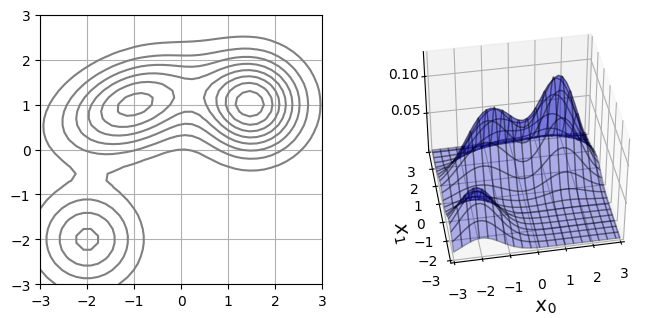

In [19]:
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

# **9.3.3 EM 알고리즘의 개요**

가우시안 혼합 모델을 이용한 데이터의 클러스터링 수행, 여기에서는 EM 알고리즘을 사용한 가우시안 혼합 모델을 데이터에 피팅해보고 부담률 γ 에 대해 구하는 방법을 설명,

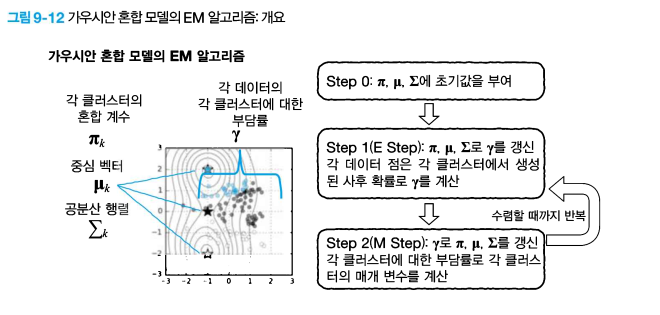

보면 알겠지만, EM은 Kmeans와 다를게 없다는 사실. 각 클러스터의 중심 벡터를 μ 로 특정했지만, 가우시안에서는 μ와 더불어 공분산 행렬 Σ에 의해 각 클러스터의 확산 정도를 기술한다는 차이가 있다.

STEP 0 : π μ Σ 의 초기화

STEP 1(E-Step) : 현시점의 π, μ, Σ 를 사용해 γ 를 구한다. K-means 에서는 출력이 R 이었지만, 가우시안에서는 각 클래스에 속할 확률에 대응하는 부담률 γ를 출력한다.  

STEP 2(M-Step) : 현시점의 γ 를 사용해서 π, μ, Σ 를 구한다.

# **9.3.4 Step 0 : 변수의 준비 및 초기화**

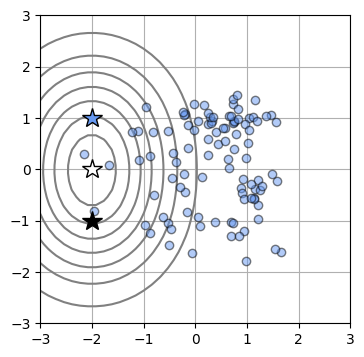

In [20]:
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ------------------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)


    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

혼합 계수 = [0.33, 0.33, 0.34]  
클러스터의 중심 벡터 = [[-2, -1], [-2, 0], [-2, 1]]  
클러스터의 공분산 행렬 sigma = [[[1, 0][0,1]]... 으로 나타냈고,  
위와 같은 그림을 얻을 수 있다.

# **9.3.5 Step 1(E step) : γ 갱신**

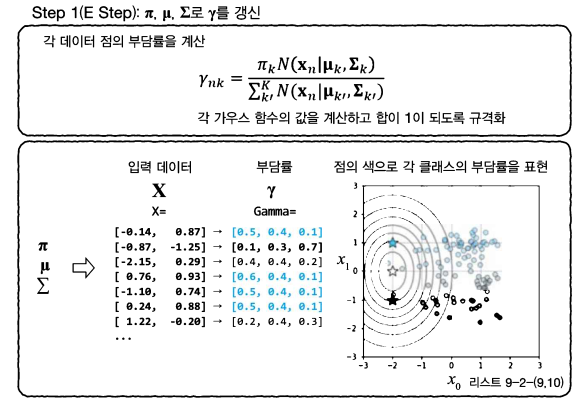

모든 n 과 k를 통해 γ를 갱신한다. 각 데이터에 대한 가우스 함수의 높이를 구하고, 그 높이의 평균값을 구한 것을 $γ_{nk}$ 로 나타낸다.

In [21]:
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 ----------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

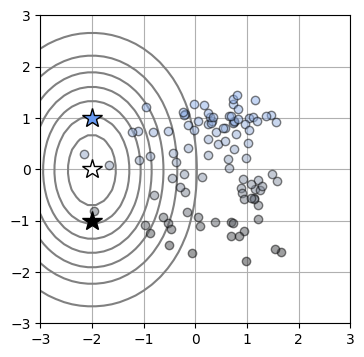

In [22]:
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

# **9.3.6 Step 2 (M Step) π, μ, Σ의 갱신**

각 클러스터에 대한 부담률의 합 $N_k$ 를 구한다.

$N_k$을 N으로 나눈 것이 혼합률 π가 된다.

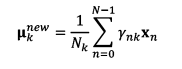

위와 같은 식으로, 혼합률에 대한 갱신을 할 수 있다.

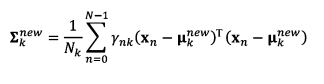

위의 식으로 공분산을 갱신할 수 있다.

In [23]:
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ----------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

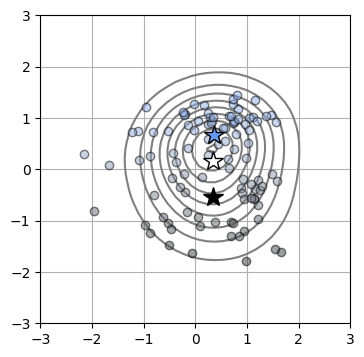

In [24]:
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

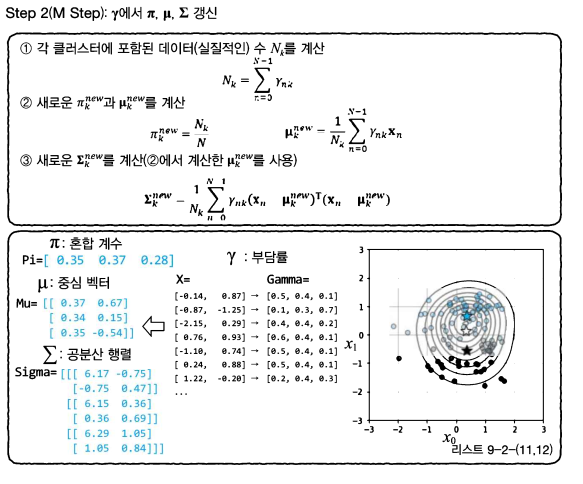

이제 우리가 할것은 변화가 없을 때 까지, 즉 이전과의 차이가 0이 될 때 까지, E-step 과 M-step을 반복하는 것이다.

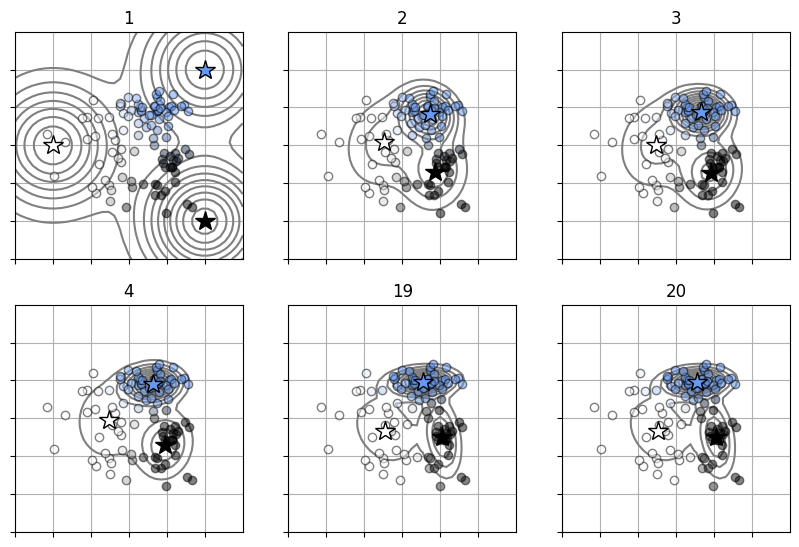

In [25]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

# **9.3.7 가능도**

가우시안 혼합 모델은 데이터의 분포 p(x) 를 나타내는 모델로, 각 가우스 분포가 각각의 클러스터 (클래스) 를 나타내고 있었다고 보면 된다. 이때, 가우스 함수의 목적함수는 무엇이면, 무엇을 최적화 하고 있었는가가 궁금한데, 이 개념이 바로 가능도 라는 개념이다. 가능도는 우리가 가지는 가우시안 분포(정규 분포) 의 y 축의 값을 말한다고 생각할 수 있다. 우리가 위에서 사용한 개념이 가능도 였던 것이다. 또한 생성된 확률(가능도) 가 가장 높도록 매개 변수가 갱신되고 있었다. 가능도는 모든 데이터 점 X 가 모델에서 생성된 확률 이기에 아래 식과 같이 표현할 수 있다.

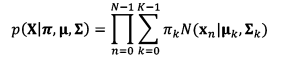

log를 취한다면, 곱을 합으로 치환할 수 있으며, 계산이 용이해진다는 장점이 있다.

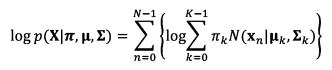

로그 가능도를 최적화 할때는 극대화 하는 값을 찾기 때문에 그 반대인 -1 을 곱한 음의 로그 가능도를 정의 하는데, 그냥 - 붙힌 버전이다.

In [28]:
# 혼합 가우스의 목적 함수 ----------------------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


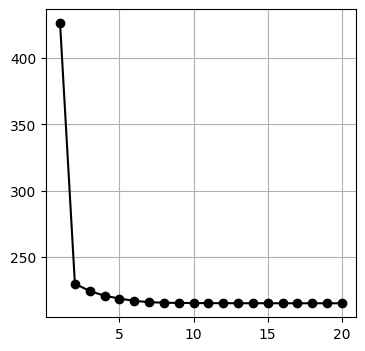

In [29]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()

위의 그림은 합수 횟수에 따른 손실함수의 값의 변화를 나타낸 것이다.